# Cross Selling Insruance

_____

# Appendix

## i. Import Libraries

In [137]:
# Data Manipulation
import psycopg2      as pg
import pandas        as pd
import pandas.io.sql as psql
import numpy         as np


# Preprocessing data
from category_encoders            import TargetEncoder, CountEncoder
from sklearn                      import preprocessing   as pp
from sklearn                      import model_selection as ms
from sklearn.kernel_approximation import Nystroem
from sklearn.decomposition        import SparsePCA
from sklearn.decomposition        import TruncatedSVD

# Data Visualization
import seaborn              as     sns
import scikitplot           as     skplot 
from   matplotlib           import pyplot    as plt
from   IPython.display      import Image
from   IPython.core.display import HTML

# Model
from sklearn                import ensemble  as en
from sklearn                import neighbors as nb
from sklearn.linear_model   import LogisticRegression, SGDClassifier
from sklearn                import svm
from sklearn.ensemble       import RandomForestClassifier

## ii. Helper Functions

In [2]:
#=====================
# DATA VISUALIZARION
#=====================
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


# 2.0. Data Understanding

## 2.1. Collect Initial Data

In [3]:
#===============
#  Credentials
#===============
host = 'comunidade-ds-postgres.c50pcakiuwi3.us-east-1.rds.amazonaws.com'
port = 5432
database = 'comunidadedsdb'
username = 'member'
pwd = 'cdspa'

In [4]:
conn = pg.connect(  user = username,
                    password = pwd,
                    host = host,
                    port = port,
                    database = database )

In [5]:
cursor = conn.cursor()

query_schema = '''
                SELECT nspname
                FROM pg_catalog.pg_namespace

'''

cursor.execute( query_schema )

record = cursor.fetchall()
cursor.close() # encerrar consulta 
conn.close()   # encerrar conexão

### Table Query

In [6]:
cursor = conn.cursor()

query_table = '''
                SELECT tablename
                FROM pg_tables
                WHERE schemaname = 'pa004'

'''

cursor.execute( query_table )

record = cursor.fetchall()
print( record )

cursor.close() # encerrar consulta 
conn.close()   # encerrar conexão

InterfaceError: connection already closed

### Collect Data using Psycopg2

In [ ]:
cursor = conn.cursor()

query_table_users = '''
                SELECT *
                FROM pa004.users u
                WHERE u.age > 44
                LIMIT 10

'''

cursor.execute( query_table_users )

record = cursor.fetchall()
print( record )

cursor.close() # encerrar consulta 
conn.close()   # encerrar conexão

[(2, 'Male', 76, 3.0, 26.0), (3, 'Male', 47, 28.0, 26.0), (8, 'Female', 56, 28.0, 26.0), (11, 'Female', 47, 35.0, 124.0), (14, 'Male', 76, 28.0, 13.0), (15, 'Male', 71, 28.0, 30.0), (20, 'Female', 60, 33.0, 124.0), (21, 'Male', 65, 28.0, 124.0), (22, 'Male', 49, 28.0, 124.0), (27, 'Female', 51, 28.0, 124.0)]


In [ ]:
data = pd.DataFrame( record )
data.head()

,0,1,2,3,4
0,2,Male,76,3.0,26.0
1,3,Male,47,28.0,26.0
2,8,Female,56,28.0,26.0
3,11,Female,47,35.0,124.0
4,14,Male,76,28.0,13.0


### Collect Data Using Pandas

In [7]:
conn = pg.connect(  user = username,
                    password = pwd,
                    host = host,
                    port = port,
                    database = database )

In [5]:
query_table_users = '''
                SELECT *
                FROM pa004.users u  LEFT JOIN pa004.vehicle  v ON ( u.id = v.id )
                                    LEFT JOIN pa004.insurance i ON ( u.id = i.id )
'''

df = psql.read_sql( query_table_users, conn )
df.head()

/var/folders/2v/3xmrj4ts6psb7j4nt0tr75980000gn/T/ipykernel_35548/3398893193.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = psql.read_sql( query_table_users, conn )


,id,gender,age,region_code,policy_sales_channel,id,driving_license,vehicle_age,vehicle_damage,id,previously_insured,annual_premium,vintage,response
0,7,Male,23,11.0,152.0,7,1,< 1 Year,Yes,7,0,23367.0,249,0
1,13,Female,41,15.0,14.0,13,1,1-2 Year,No,13,1,31409.0,221,0
2,18,Female,25,35.0,152.0,18,1,< 1 Year,No,18,1,46622.0,299,0
3,31,Female,26,8.0,160.0,31,1,< 1 Year,No,31,0,2630.0,136,0
4,39,Male,45,8.0,124.0,39,1,1-2 Year,Yes,39,0,42297.0,264,0


In [6]:
# Remooving duplicated columns
df_raw = df.loc[:,~df.columns.duplicated()].copy()
df_raw.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
0,7,Male,23,11.0,152.0,1,< 1 Year,Yes,0,23367.0,249,0
1,13,Female,41,15.0,14.0,1,1-2 Year,No,1,31409.0,221,0
2,18,Female,25,35.0,152.0,1,< 1 Year,No,1,46622.0,299,0
3,31,Female,26,8.0,160.0,1,< 1 Year,No,0,2630.0,136,0
4,39,Male,45,8.0,124.0,1,1-2 Year,Yes,0,42297.0,264,0


## 2.2. Describe Data

### 2.2.1. Data Dimensions

In [7]:
print( 'Number of records  : {}'.format( df_raw.shape[0] ) )
print( 'Number of Features : {}'.format( df_raw.shape[1] ) )

Number of records  : 381109
Number of Features : 12


### 2.2.2. Data Type

In [8]:
df_raw.dtypes

id                        int64
gender                   object
age                       int64
region_code             float64
policy_sales_channel    float64
driving_license           int64
vehicle_age              object
vehicle_damage           object
previously_insured        int64
annual_premium          float64
vintage                   int64
response                  int64
dtype: object

## 2.3. Verify Data Quality

### 2.4.1. Datatype Changes Riquired

In [9]:
df2 = df_raw.copy()

In [10]:
# float to int64
df2['region_code'] = df2['region_code'].astype( 'object' )
df2['policy_sales_channel'] = df2['policy_sales_channel'].astype( 'int64' )
df2['annual_premium'] = df2['annual_premium'].astype( 'int64' )

df2.head()


,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
0,7,Male,23,11.0,152,1,< 1 Year,Yes,0,23367,249,0
1,13,Female,41,15.0,14,1,1-2 Year,No,1,31409,221,0
2,18,Female,25,35.0,152,1,< 1 Year,No,1,46622,299,0
3,31,Female,26,8.0,160,1,< 1 Year,No,0,2630,136,0
4,39,Male,45,8.0,124,1,1-2 Year,Yes,0,42297,264,0


In [11]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   id                    381109 non-null  int64 
 1   gender                381109 non-null  object
 2   age                   381109 non-null  int64 
 3   region_code           381109 non-null  object
 4   policy_sales_channel  381109 non-null  int64 
 5   driving_license       381109 non-null  int64 
 6   vehicle_age           381109 non-null  object
 7   vehicle_damage        381109 non-null  object
 8   previously_insured    381109 non-null  int64 
 9   annual_premium        381109 non-null  int64 
 10  vintage               381109 non-null  int64 
 11  response              381109 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 34.9+ MB


### 2.4.2. Check for existing missing values in data

In [12]:
df2.isna().sum()

id                      0
gender                  0
age                     0
region_code             0
policy_sales_channel    0
driving_license         0
vehicle_age             0
vehicle_damage          0
previously_insured      0
annual_premium          0
vintage                 0
response                0
dtype: int64

## 2.5. Descriptive Statistics

In [13]:
df2.describe().T

,count,mean,std,min,25%,50%,75%,max
id,381109.0,190555.000000,110016.836208,1.0,95278.0,190555.0,285832.0,381109.0
age,381109.0,38.822584,15.511611,20.0,25.0,36.0,49.0,85.0
policy_sales_channel,381109.0,112.034295,54.203995,1.0,29.0,133.0,152.0,163.0
driving_license,381109.0,0.997869,0.046110,0.0,1.0,1.0,1.0,1.0
previously_insured,381109.0,0.458210,0.498251,0.0,0.0,0.0,1.0,1.0
annual_premium,381109.0,30564.389581,17213.155057,2630.0,24405.0,31669.0,39400.0,540165.0
vintage,381109.0,154.347397,83.671304,10.0,82.0,154.0,227.0,299.0
response,381109.0,0.122563,0.327936,0.0,0.0,0.0,0.0,1.0


# 3. Data Preparation

In [14]:
df3 = df2.copy()

## 3.2. Exploratory Data Analisys

In [15]:
df32 = df3.copy()

<AxesSubplot: xlabel='gender', ylabel='Count'>

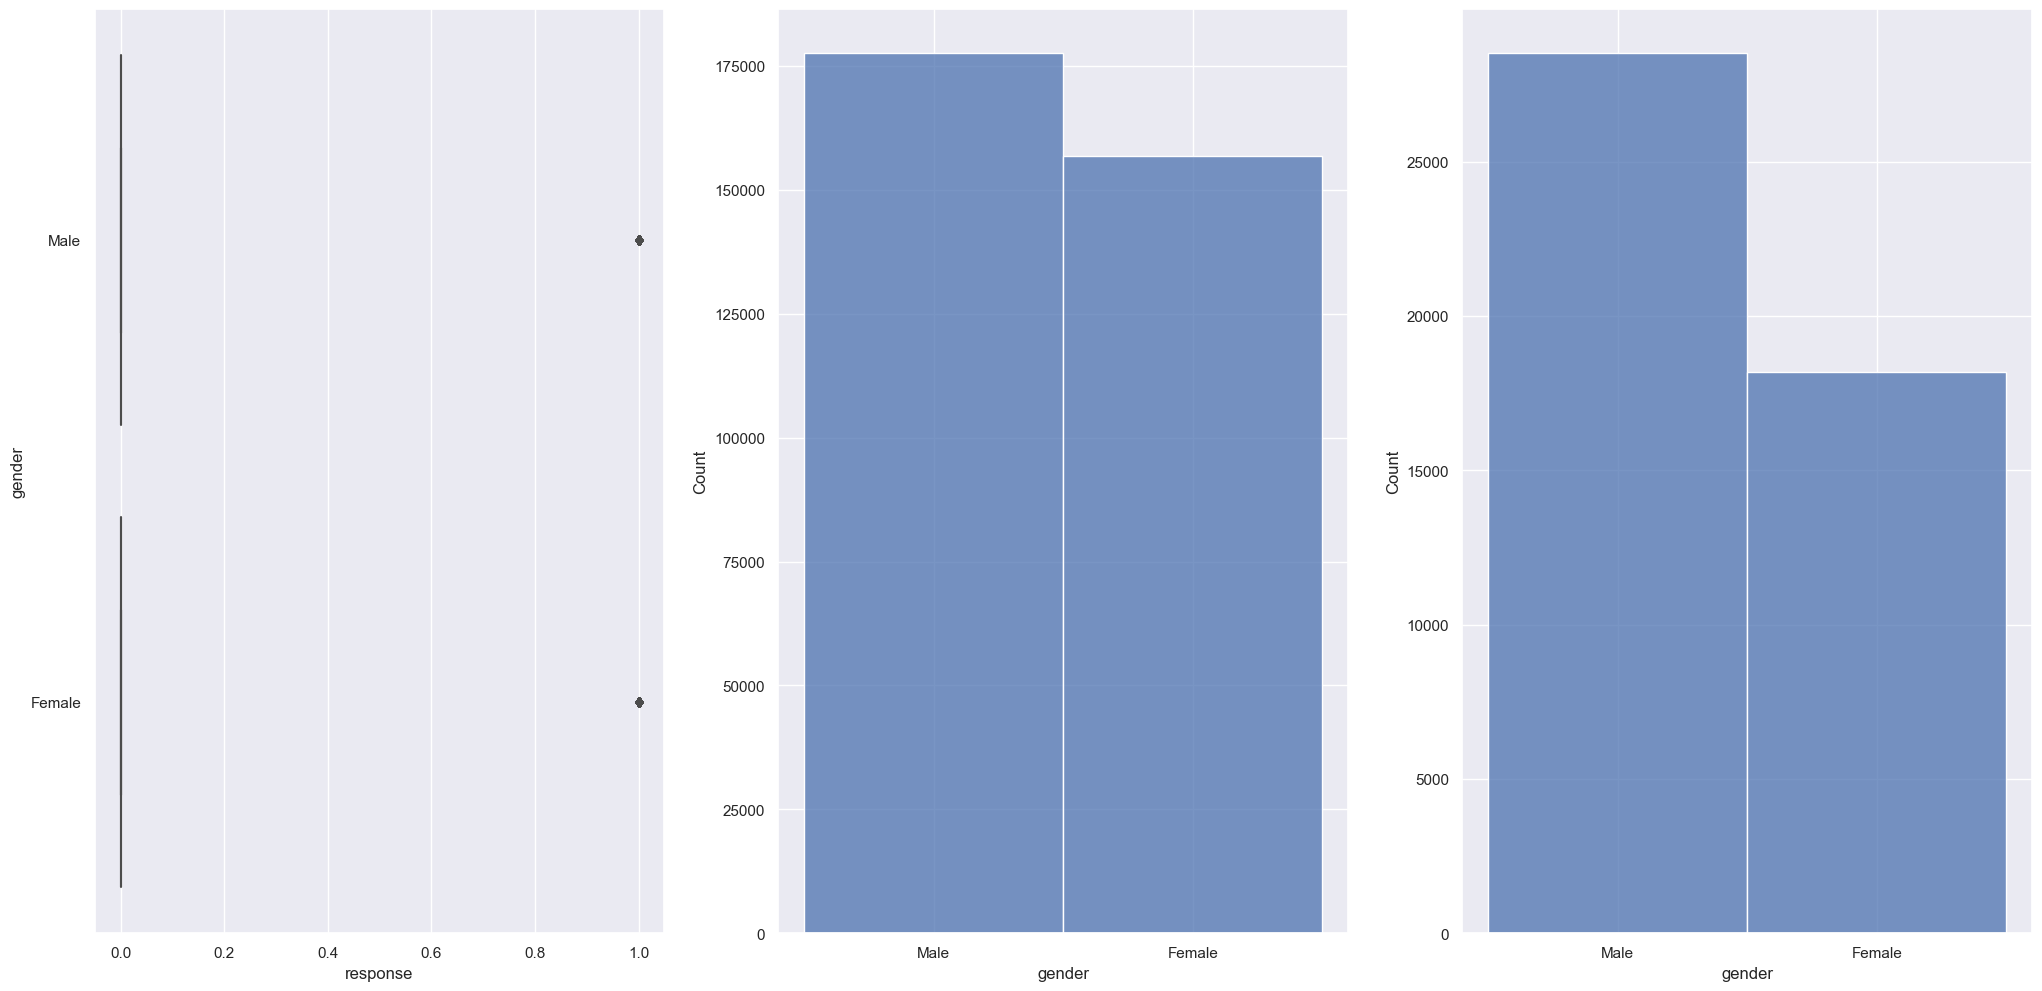

In [16]:
# 'gender'
plt.subplot(1,3,1)
sns.boxplot( x='response', y='gender', data=df32)

plt.subplot(1,3,2)
aux1 = df32.loc[df32['response'] == 0, 'gender']
sns.histplot( aux1 )

plt.subplot(1,3,3)
aux2 = df32.loc[df32['response'] == 1, 'gender']
sns.histplot( aux2 )

<AxesSubplot: xlabel='age', ylabel='Count'>

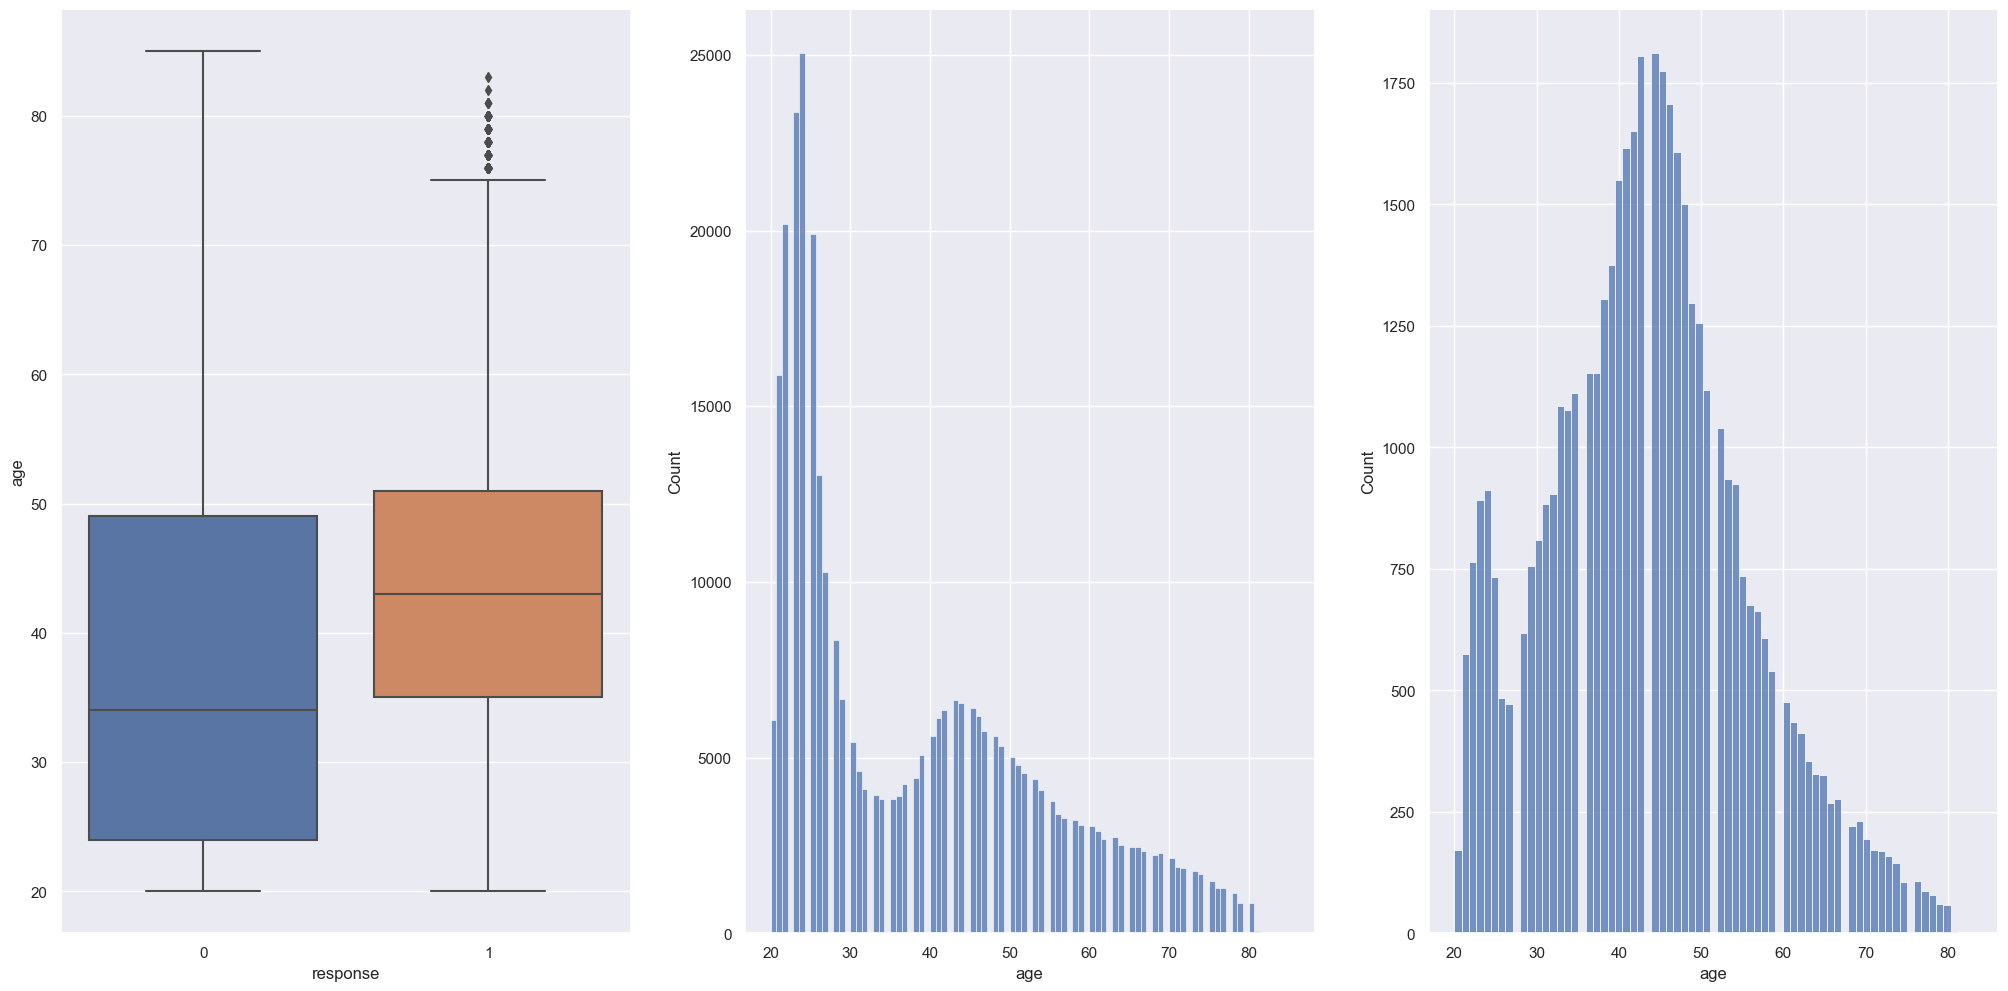

In [17]:
# 'age'
plt.subplot(1,3,1)
sns.boxplot( x='response', y='age', data=df32)

plt.subplot(1,3,2)
aux1 = df32.loc[df32['response'] == 0, 'age']
sns.histplot( aux1 )

plt.subplot(1,3,3)
aux2 = df32.loc[df32['response'] == 1, 'age']
sns.histplot( aux2 )

In [18]:
# 'region_code'
pd.crosstab(df32['response'],df32['region_code'], normalize=True)

region_code,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0,24.0,25.0,26.0,27.0,28.0,29.0,30.0,31.0,32.0,33.0,34.0,35.0,36.0,37.0,38.0,39.0,40.0,41.0,42.0,43.0,44.0,45.0,46.0,47.0,48.0,49.0,50.0,51.0,52.0
response,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.004846,0.002359,0.009842,0.021175,0.003978,0.002968,0.015326,0.007470,0.080344,0.007473,0.010787,0.021493,0.007573,0.009635,0.011167,0.032405,0.004915,0.006384,0.011742,0.003372,0.004492,0.010399,0.003217,0.004356,0.005439,0.006287,0.006297,0.006859,0.226964,0.025452,0.029627,0.004626,0.006686,0.018089,0.004036,0.015946,0.021238,0.013290,0.004295,0.010679,0.002997,0.042085,0.001435,0.006284,0.002034,0.013093,0.046488,0.017801,0.011031,0.004448,0.025192,0.000407,0.000614
1,0.000457,0.000286,0.000753,0.003099,0.000748,0.000388,0.001152,0.001134,0.008546,0.000664,0.000690,0.002732,0.000819,0.000955,0.001107,0.002514,0.000352,0.000483,0.001779,0.000656,0.000585,0.000795,0.000218,0.000787,0.000897,0.000281,0.000491,0.000548,0.052261,0.003582,0.002362,0.000517,0.000627,0.001994,0.000331,0.002270,0.001845,0.001144,0.001021,0.001506,0.000401,0.005836,0.000115,0.000640,0.000087,0.001614,0.005332,0.001711,0.001252,0.000359,0.001685,0.000073,0.000087


<AxesSubplot: xlabel='region_code', ylabel='id'>

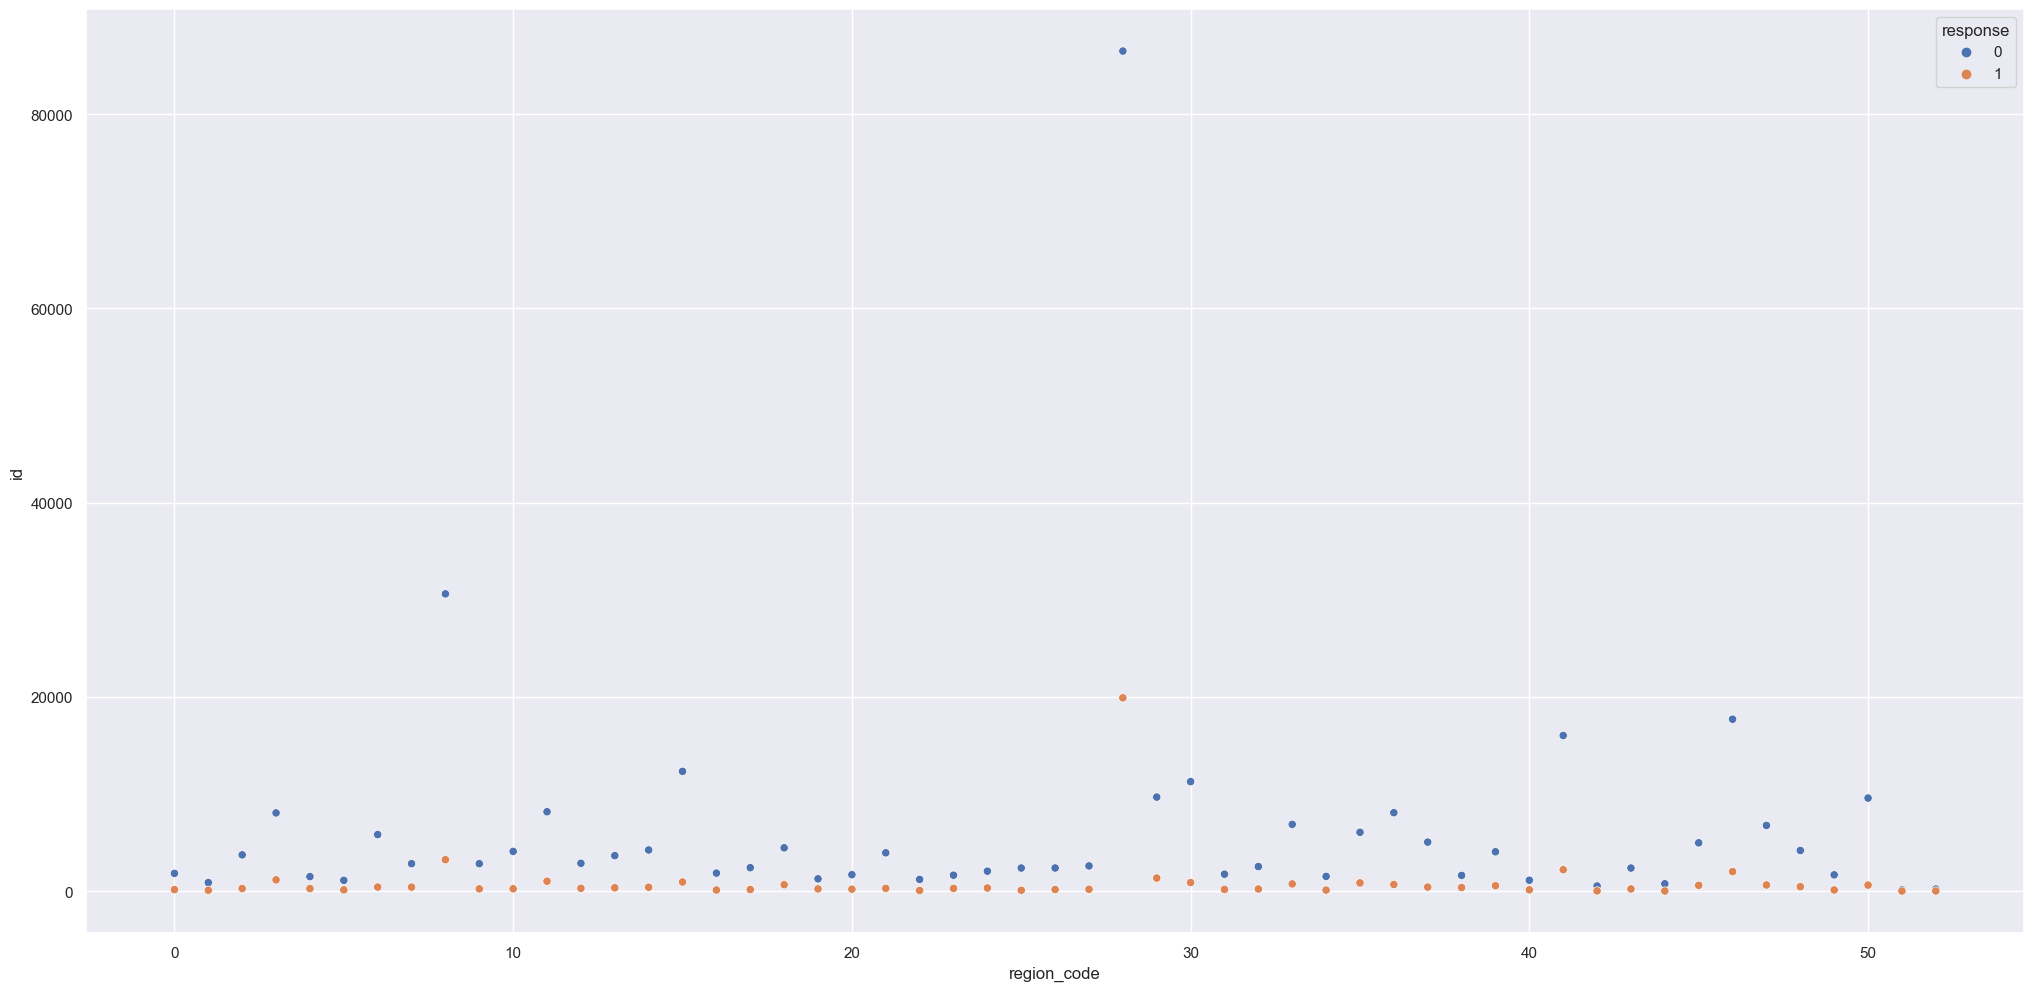

In [19]:
# 'region_code'
aux = df32[['id','region_code','response']].groupby( ['region_code','response'] ).count().reset_index()
sns.scatterplot( x='region_code', y='id', hue='response', data=aux)

In [20]:
# 'policy_sales_channel'


In [21]:
# 'driving_license'
aux = df32[['driving_license','response']].groupby( 'response' ).sum().reset_index()
aux.head()
pd.crosstab(df32['driving_license'],df32['response']).apply( lambda x: x / x.sum(), axis=1 )

response,0,1
driving_license,,
0,0.949507,0.050493
1,0.877283,0.122717


In [22]:
# 'vehicle_damage'


In [23]:
# 'previously_insured'
pd.crosstab(df32['previously_insured'],df32['response']).apply( lambda x: x / x.sum(), axis=1 )

response,0,1
previously_insured,,
0,0.774546,0.225454
1,0.999095,0.000905


<AxesSubplot: xlabel='annual_premium', ylabel='Count'>

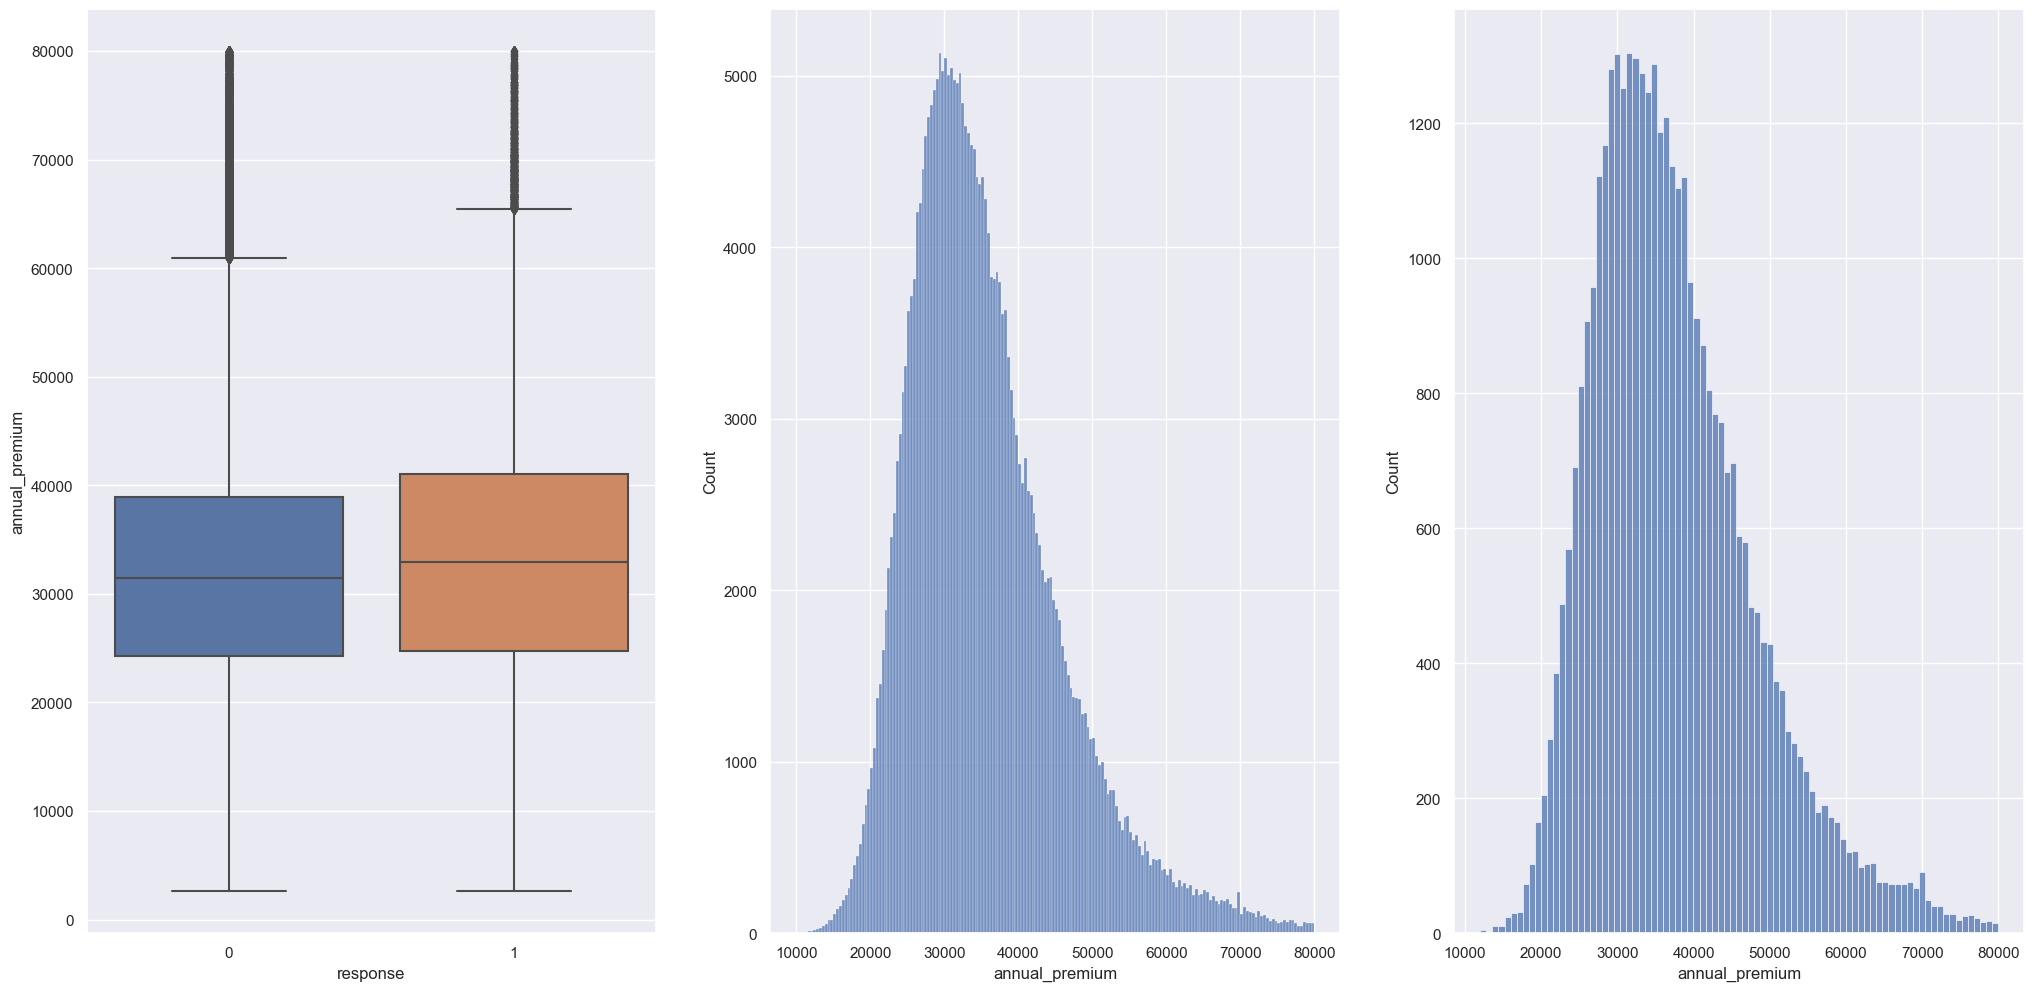

In [24]:
# 'annual_premium'
plt.subplot(1,3,1)
aux1 = df32[df32['annual_premium'] < 80000 ]
sns.boxplot( x='response', y='annual_premium', data=aux1)

plt.subplot(1,3,2)
aux0 = df32[(df32['annual_premium'] > 10000 ) & (df32['annual_premium'] < 80000 ) ]
aux2 = aux0.loc[aux0['response'] == 0, 'annual_premium']
sns.histplot( aux2 )

plt.subplot(1,3,3)
aux2 = aux0.loc[aux0['response'] == 1, 'annual_premium']
sns.histplot( aux2 )

<AxesSubplot: xlabel='vintage', ylabel='Count'>

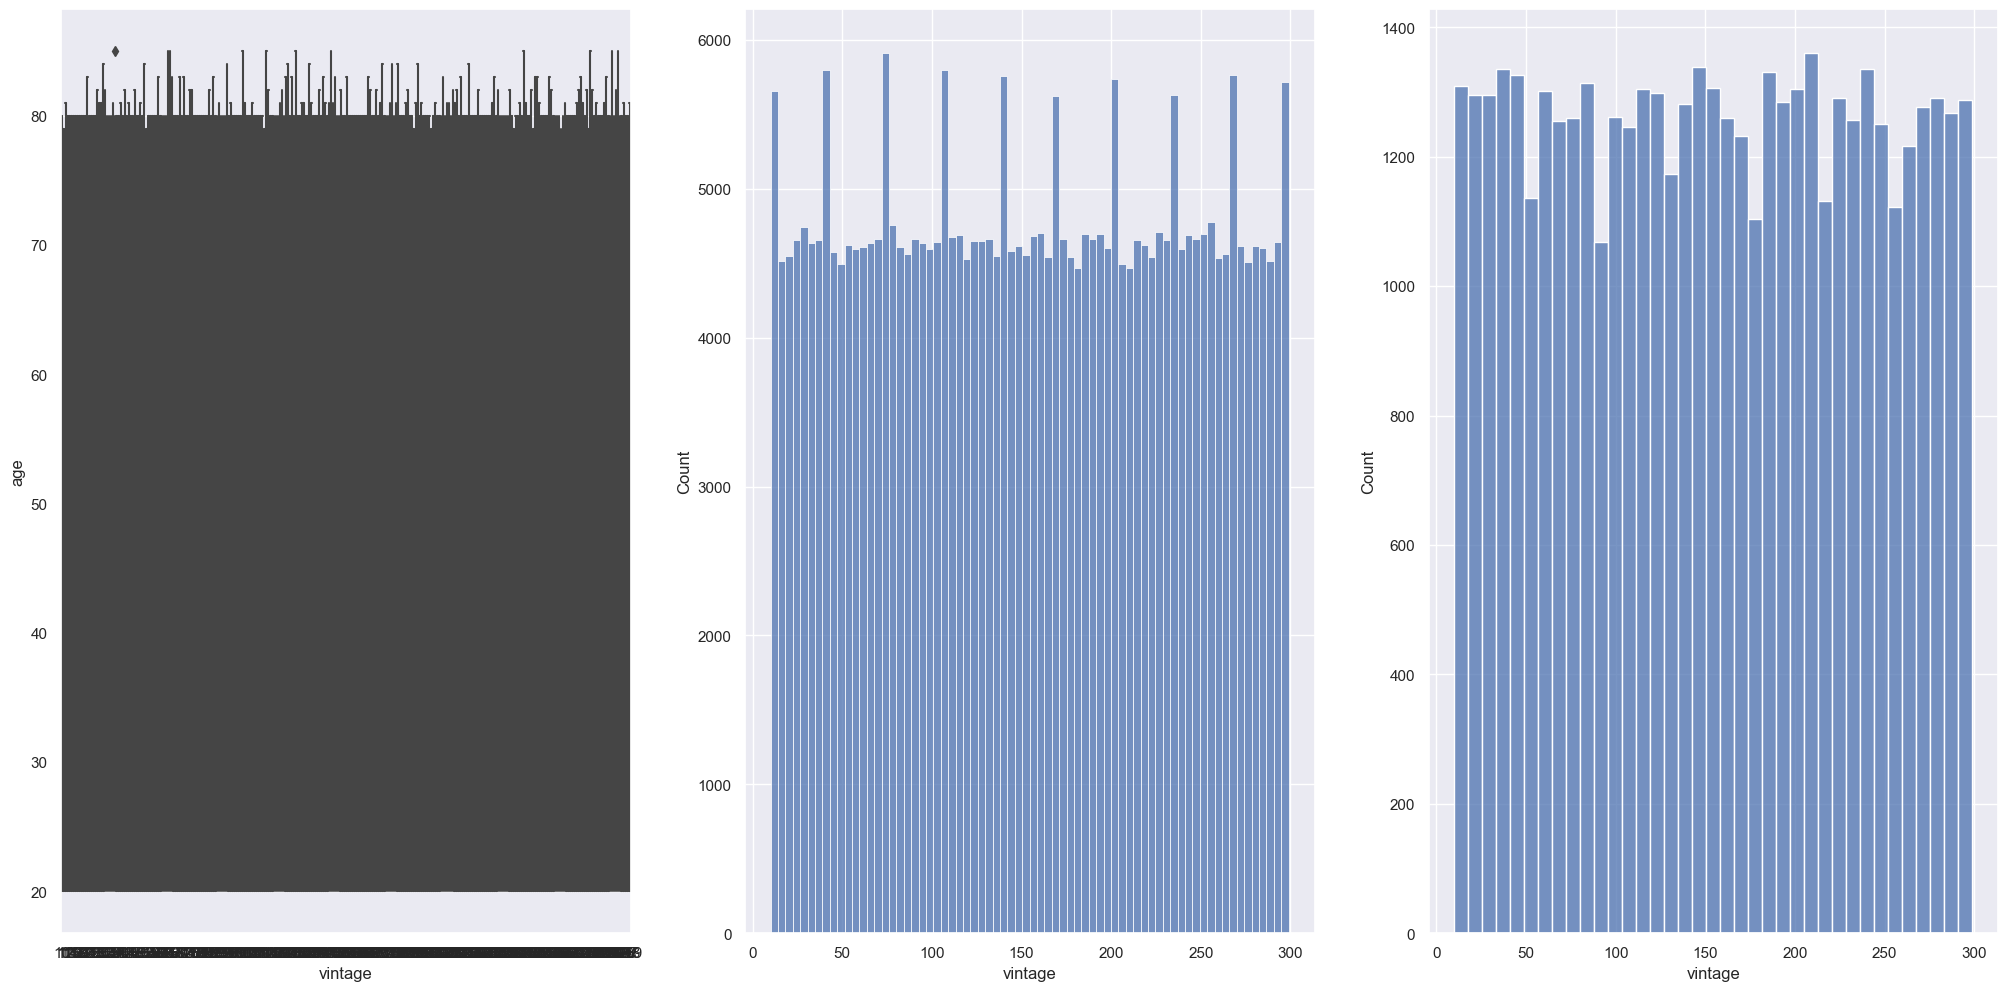

In [25]:
# 'vintage'
plt.subplot(1,3,1)
sns.boxplot( x='vintage', y='age', data=df32)

plt.subplot(1,3,2)
aux1 = df32.loc[df32['response'] == 0, 'vintage']
sns.histplot( aux1 )

plt.subplot(1,3,3)
aux2 = df32.loc[df32['response'] == 1, 'vintage']
sns.histplot( aux2 )

In [26]:
# 'response'


In [27]:
# 'vehicle_age_encoded'
df32[['vehicle_age','response']].value_counts( normalize=True).reset_index().sort_values(by=['vehicle_age'])

,vehicle_age,response,0
0,1-2 Year,0,0.434285
2,1-2 Year,1,0.091328
1,< 1 Year,0,0.413488
4,< 1 Year,1,0.018897
3,> 2 Years,0,0.029663
5,> 2 Years,1,0.012338


## 3.3. Bivariate Analysis

## 3.4. Multivariable Analysis

/var/folders/2v/3xmrj4ts6psb7j4nt0tr75980000gn/T/ipykernel_35548/1482159620.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = df32.corr( method= 'pearson' )


<AxesSubplot: >

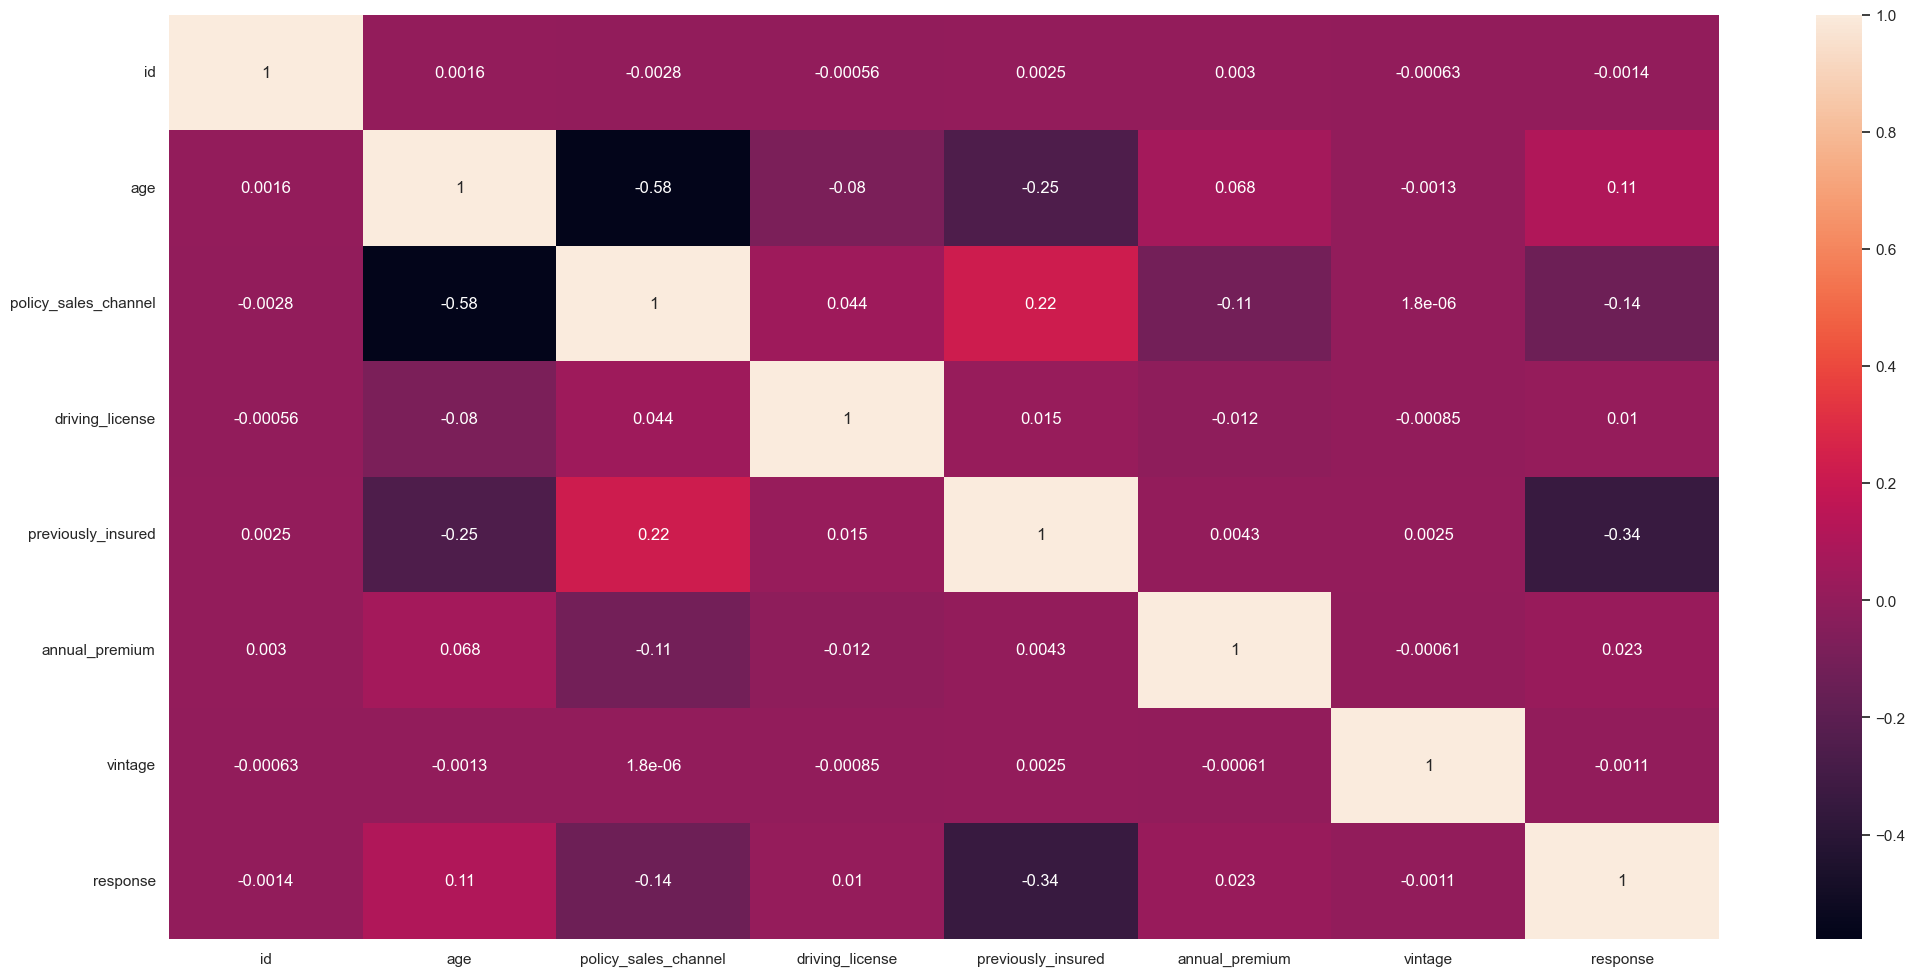

In [28]:
correlation = df32.corr( method= 'pearson' )
sns.heatmap( correlation, annot=True )

## 4. Data Preparation

In [309]:
df4 = df3.copy()

## 4.1. Split dataset

In [310]:
X = df4.drop( 'response', axis=1 )
y = df4['response'].copy()

x_train, x_val, y_train, y_val = ms.train_test_split( X, y, test_size=0.20 )

df4 = pd.concat( ( x_train, y_train ), axis=1 )

In [311]:
# Binary variable

# GENDER
df4['gender'] = df4['gender'].map({'Male':1, 'Female':0})

# VEHICLE DEMAGE 
df4['vehicle_damage'] = df4['vehicle_damage'].map({'Yes':1, 'No':0})
df4.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
172743,237586,0,27,5.0,152,1,< 1 Year,0,0,2630,259,0
98880,26542,0,23,50.0,152,1,< 1 Year,0,1,27768,188,0
286670,3585,1,67,3.0,26,1,1-2 Year,0,0,40187,130,0
26346,210213,1,24,10.0,160,1,< 1 Year,0,1,25631,235,0
364562,249673,1,44,3.0,124,1,1-2 Year,0,1,31715,44,0


### Standardization

In [312]:
ss = pp.StandardScaler()

# annual_premium
df4['annual_premium'] = ss.fit_transform( df4[['annual_premium']].values )


### Rescaling

In [313]:
# age
mms_age = pp.MinMaxScaler()
df4['age'] = mms_age.fit_transform(df4[['age']].values)


# vintage
mms_vintage = pp.MinMaxScaler()
df4['vintage'] = mms_age.fit_transform(df4[['vintage']].values)

### Encoder

In [314]:
# region_code - [Frequecy Encoding] / Target
count_encoder_region = CountEncoder()
df4['region_code'] = count_encoder_region.fit_transform( df4['region_code'], df4['response'] )
mms_region = pp.MinMaxScaler()
df4['region_code'] = mms_region.fit_transform(df4[['region_code']].values)

In [315]:
# policy_sales_channel - [Target Encoding] / Frequency Encoding
target_encoder_channel = TargetEncoder()
df4['policy_sales_channel'] = target_encoder_channel.fit_transform( df4['policy_sales_channel'], df4['response'] )

mms_channel = pp.MinMaxScaler()
df4['policy_sales_channel'] = mms_channel.fit_transform(df4[['policy_sales_channel']].values)

df4.head()

/Users/puppim/Documents/GitHub/Data-Science-Portifolio/Cross-Selling_Insurance/.venv_pa04_2/lib/python3.9/site-packages/category_encoders/target_encoder.py:122: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
/Users/puppim/Documents/GitHub/Data-Science-Portifolio/Cross-Selling_Insurance/.venv_pa04_2/lib/python3.9/site-packages/category_encoders/target_encoder.py:127: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."


,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
172743,237586,0,0.107692,0.010484,0.932099,1,< 1 Year,0,0,-1.621289,0.861592,0
98880,26542,0,0.046154,0.094556,0.932099,1,< 1 Year,0,1,-0.163697,0.615917,0
286670,3585,1,0.723077,0.085000,0.154321,1,1-2 Year,0,0,0.556401,0.415225,0
26346,210213,1,0.061538,0.039068,0.981481,1,< 1 Year,0,1,-0.287608,0.778547,0
364562,249673,1,0.369231,0.085000,0.759259,1,1-2 Year,0,1,0.065164,0.117647,0


In [316]:
# vehicle_age - Terget Encoding / Order Encoding / [One Hot Encoder]
# target_encoder = TargetEncoder()
# df4['vehicle_age_encoded'] = target_encoder.fit_transform( df4['vehicle_age'], df3['response'] )
df4 = pd.get_dummies( df4, prefix='vehicle_age', columns=['vehicle_age'] )

### 4.1.2. Validation data Preparation

In [317]:
# GENDER
x_val['gender'] = x_val['gender'].map({'Male':1, 'Female':0})

# VEHICLE DEMAGE 
x_val['vehicle_damage'] = x_val['vehicle_damage'].map({'Yes':1, 'No':0})

# annual_premium
x_val['annual_premium'] = ss.transform( x_val[['annual_premium']].values )

# age
x_val['age'] = mms_age.transform(x_val[['age']].values)


# vintage
x_val['vintage'] = mms_age.transform(x_val[['vintage']].values)

# region_code - [Frequecy Encoding] / Target
x_val['region_code'] = count_encoder_region.transform( x_val['region_code'] )
x_val['region_code'] = mms_region.transform(x_val[['region_code']].values)

# policy_sales_channel - [Target Encoding] / Frequency Encoding
x_val['policy_sales_channel'] = target_encoder_channel.transform( x_val['policy_sales_channel'] )
x_val['policy_sales_channel'] = mms_channel.fit_transform(x_val[['policy_sales_channel']].values)

# vehicle_age - Terget Encoding / Order Encoding / [One Hot Encoder]
x_val = pd.get_dummies( x_val, prefix='vehicle_age', columns=['vehicle_age'] )

# fillna
x_val = x_val.fillna( 0 )

In [318]:
x_val.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_damage,previously_insured,annual_premium,vintage,vehicle_age_1-2 Year,vehicle_age_< 1 Year,vehicle_age_> 2 Years
214354,187573,1,0.138408,1.000000,0.154321,1,1,0,0.338208,0.705882,1,0,0
60062,98651,1,0.231834,1.000000,0.154321,1,0,0,0.860988,0.626298,1,0,0
329877,350353,1,0.048443,0.317658,0.932099,1,0,1,0.491749,0.044983,0,1,0
117624,176982,1,0.110727,0.041995,0.759259,1,0,1,0.719682,0.162630,1,0,0
19455,155316,0,0.190311,1.000000,0.154321,1,1,0,0.378855,0.764706,1,0,0


# 5.0. Feature Selection

In [319]:
df5 = df4.copy()

Extra Trees Classifier

In [320]:
# model
forest = en.ExtraTreesClassifier( n_estimators = 250, random_state=123, n_jobs= -1 )

# data preparation
x_train_n = df5.drop( ['id','response'], axis=1 )
y_train_n = y_train.values
forest.fit( x_train_n, y_train_n )

ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=123)

Features Ranking:
                 feature  importance
0                vintage    0.269402
0         annual_premium    0.242329
0                    age    0.163907
0            region_code    0.096031
0   policy_sales_channel    0.073035
0         vehicle_damage    0.070840
0     previously_insured    0.055357
0   vehicle_age_< 1 Year    0.014498
0   vehicle_age_1-2 Year    0.006691
0                 gender    0.004855
0  vehicle_age_> 2 Years    0.002611
0        driving_license    0.000443


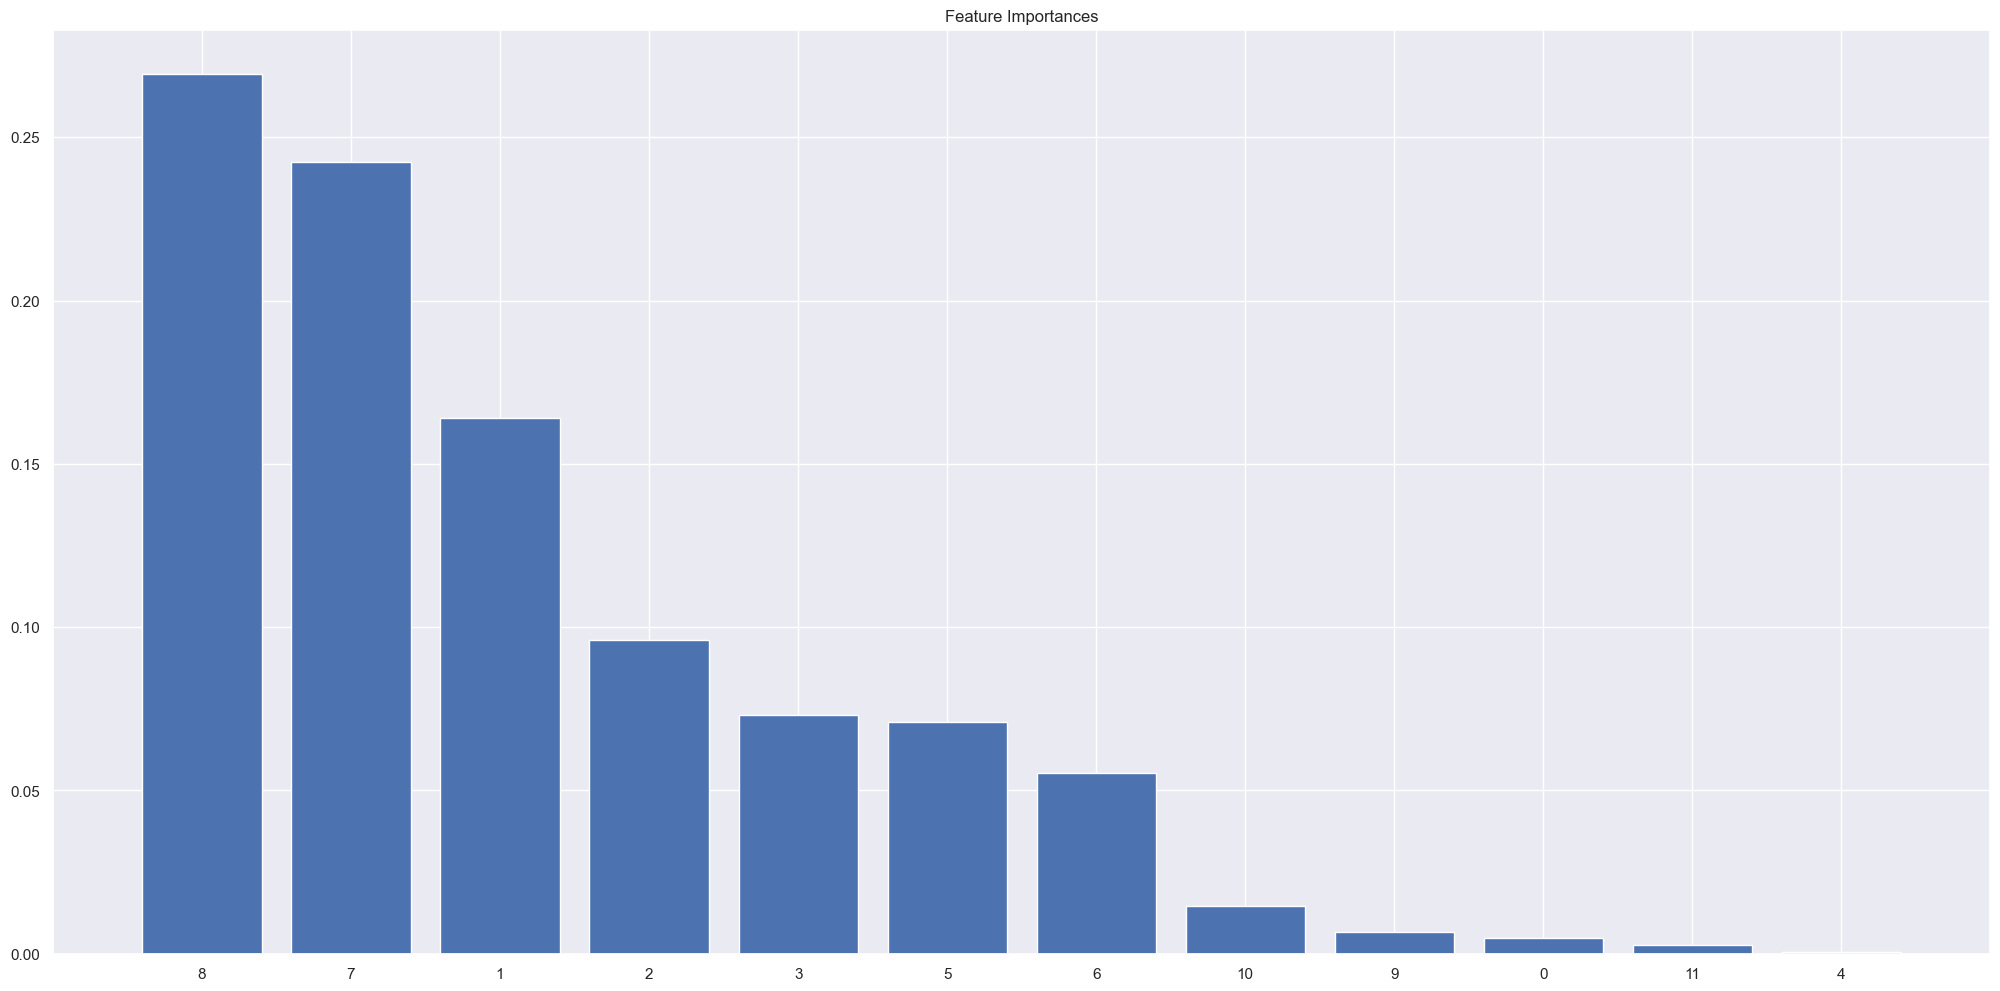

In [321]:
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the features ranking
print('Features Ranking:')
df = pd.DataFrame()
for i, j in zip( x_train_n, forest.feature_importances_):
    aux = pd.DataFrame( {'feature':i, 'importance': j}, index=[0] )
    df = pd.concat( [df,aux], axis=0 )

print( df.sort_values( 'importance', ascending=False ))

# Plot the impurity-based feature importance of the forest
plt.figure()
plt.title("Feature Importances")
plt.bar(range(x_train_n.shape[1]), importances[indices], align='center')
plt.xticks( range(x_train_n.shape[1]), indices)
plt.xlim([-1, x_train_n.shape[1]])
plt.show()

In [322]:
cols_selected = ['vintage', 'annual_premium', 'age', 
                 'region_code', 'policy_sales_channel',
                 'vehicle_damage', 'previously_insured']

In [323]:
x_val_raw = x_val
x_train = df5[ cols_selected]
x_val   = x_val[ cols_selected ]

# 6.0. Machine Learning

## 6.1. Models

### 6.1.1. KNN

In [337]:
# model
knn_model10 = nb.KNeighborsClassifier( n_neighbors=10 )
knn_model15 = nb.KNeighborsClassifier( n_neighbors=15 )
knn_model20 = nb.KNeighborsClassifier( n_neighbors=20 )
knn_model25 = nb.KNeighborsClassifier( n_neighbors=25 )
knn_model50 = nb.KNeighborsClassifier( n_neighbors=50 )

# training
knn_model10.fit( x_train, y_train )
knn_model15.fit( x_train, y_train )
knn_model20.fit( x_train, y_train )
knn_model25.fit( x_train, y_train )
knn_model50.fit( x_train, y_train )

# model prediction - poder de GENERALIZAÇÃO
yhat_knn10 =knn_model10.predict_proba( x_val )
yhat_knn15 =knn_model15.predict_proba( x_val )
yhat_knn20 =knn_model20.predict_proba( x_val )
yhat_knn25 =knn_model25.predict_proba( x_val )
yhat_knn50 =knn_model50.predict_proba( x_val )

# Accumulative Gain lr
#skplot.metrics.plot_cumulative_gain( y_val, yhat_knn50 );

<AxesSubplot: xlabel='count_id', ylabel='Interessados'>

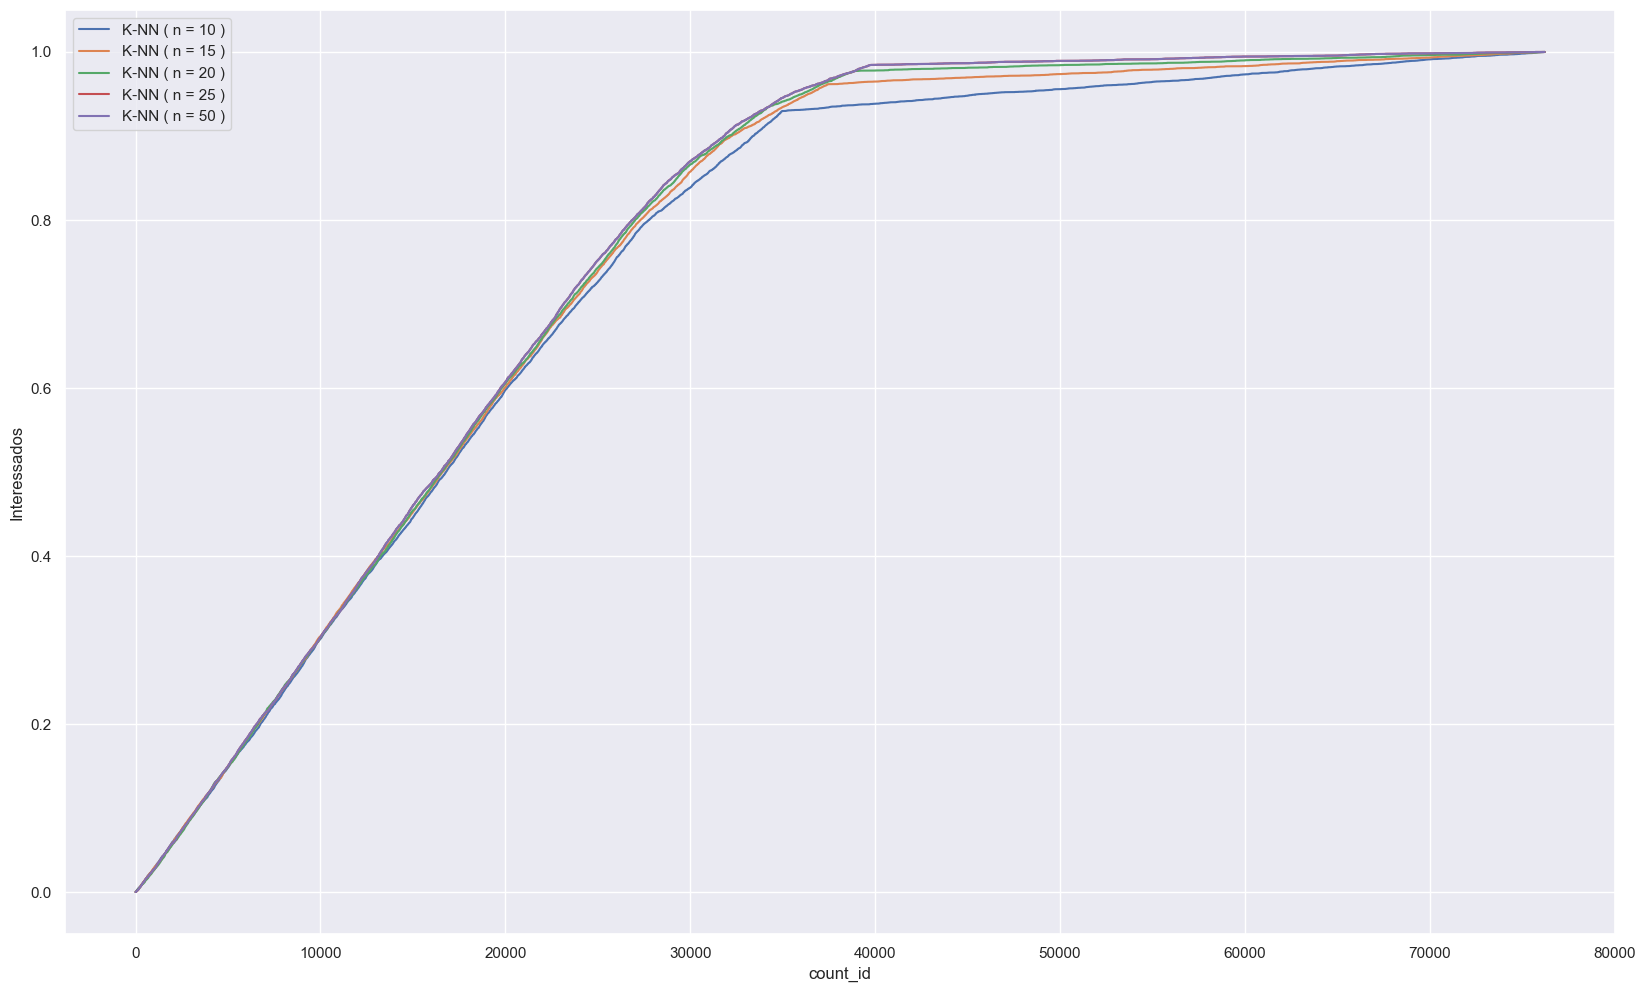

In [338]:
metrics_knn10 = perncentage_target( y_val=y_val, yhat=yhat_knn10 )
metrics_knn15 = perncentage_target( y_val=y_val, yhat=yhat_knn15 )
metrics_knn20 = perncentage_target( y_val=y_val, yhat=yhat_knn20 )
metrics_knn25 = perncentage_target( y_val=y_val, yhat=yhat_knn25 )
metrics_knn50 = perncentage_target( y_val=y_val, yhat=yhat_knn50 )

figure(figsize=(20,12))
sns.lineplot(x='count_id', y='Interessados', data=metrics_knn10 , label='K-NN ( n = 10 )')
sns.lineplot(x='count_id', y='Interessados', data=metrics_knn15 , label='K-NN ( n = 15 )')
sns.lineplot(x='count_id', y='Interessados', data=metrics_knn20 , label='K-NN ( n = 20 )')
sns.lineplot(x='count_id', y='Interessados', data=metrics_knn25 , label='K-NN ( n = 25 )')
sns.lineplot(x='count_id', y='Interessados', data=metrics_knn25 , label='K-NN ( n = 50 )')

### 6.1.2. Logistic Regression

In [326]:
# model
lr_model = LogisticRegression()

# training
lr_model.fit( x_train, y_train )

# model prediction - poder de GENERALIZAÇÃO
yhat_lr =lr_model.predict_proba( x_val )

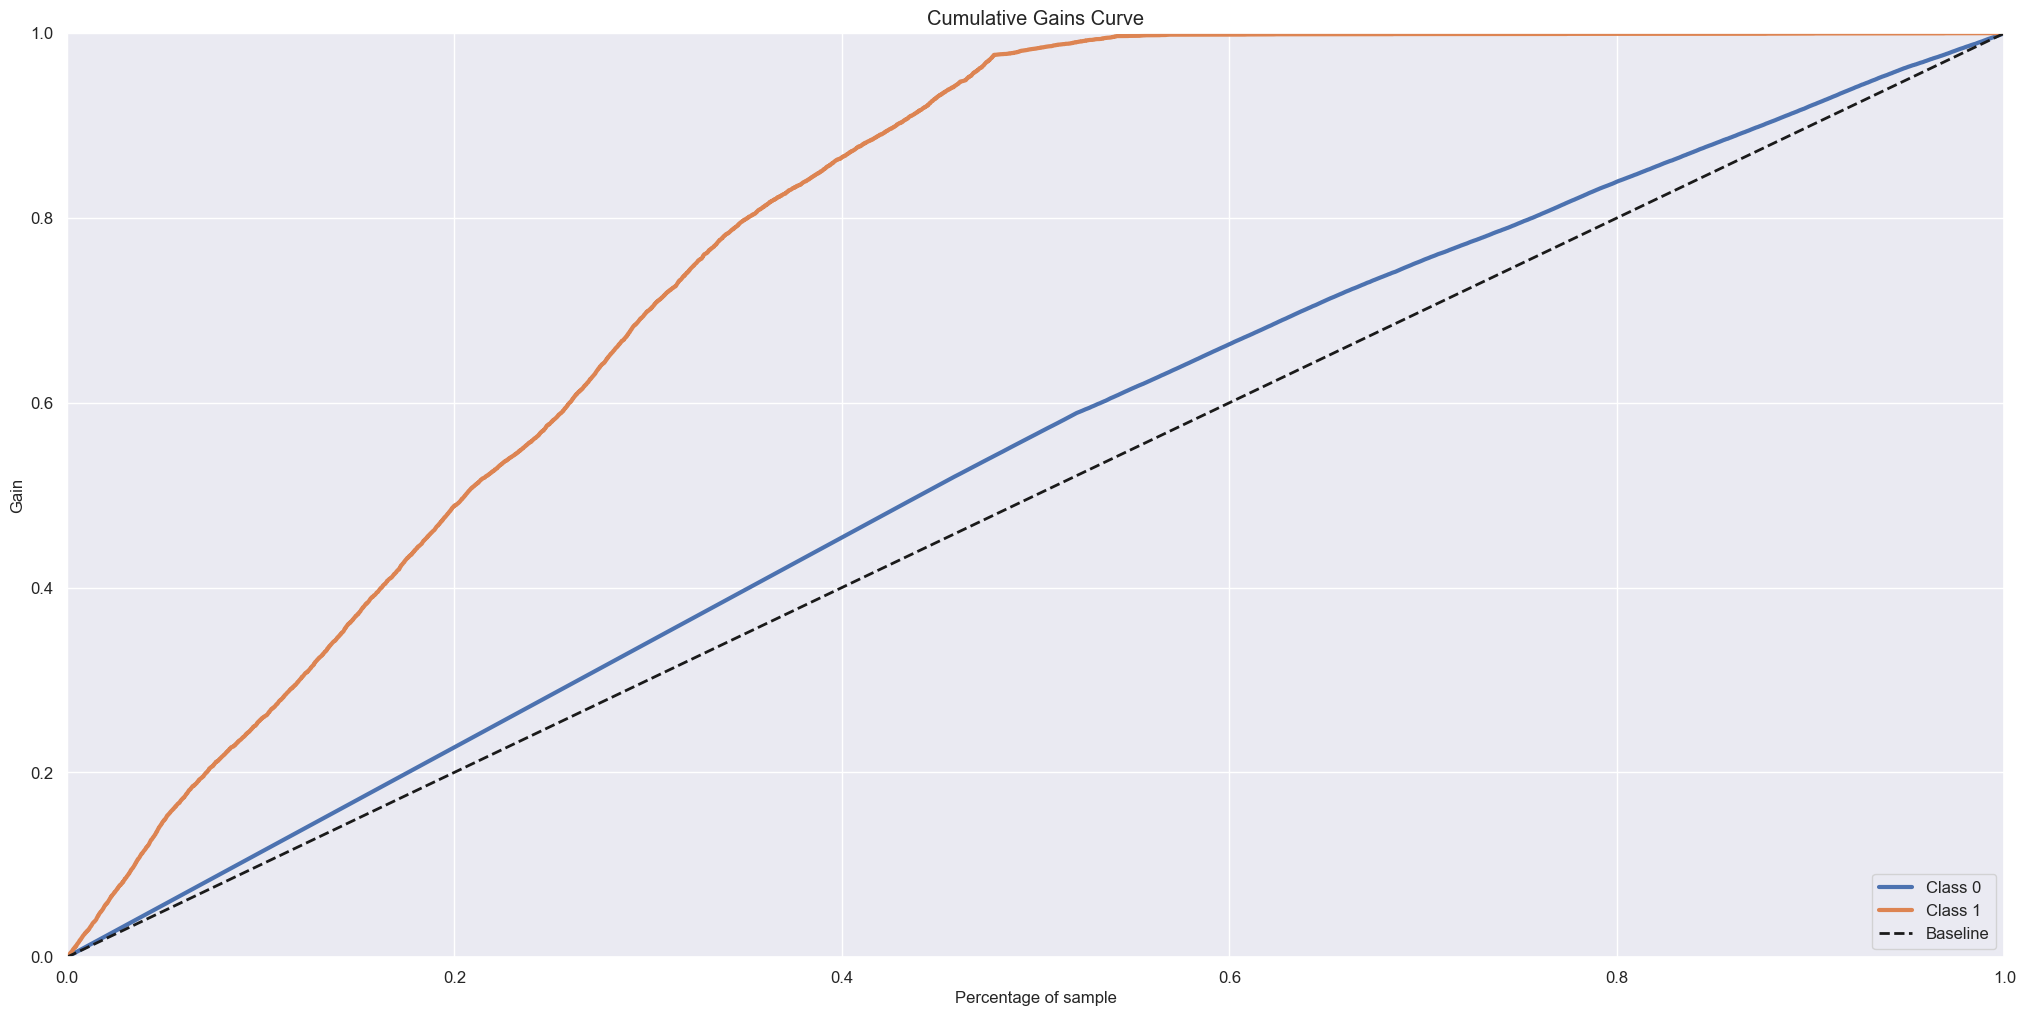

In [327]:
# Accumulative Gain lr
skplot.metrics.plot_cumulative_gain( y_val, yhat_lr );


#### SparsePCA

In [328]:
# Sparse PCA
pca4 = SparsePCA( n_components= 4, random_state= 123 )
x_train_pca4 = pca4.fit_transform( df5.drop( ['id','response'], axis=1 ) )
x_val_pca4   = pca4.fit_transform( x_val_raw.drop( ['id'], axis=1 ) )

# model
lr_model_pca4 = LogisticRegression()

# training
lr_model_pca4.fit( x_train_pca4, y_train )

# model prediction - poder de GENERALIZAÇÃO
yhat_lr_pca4 = lr_model_pca4.predict_proba( x_val_pca4 )


In [329]:
# Sparse PCA
pcaB = SparsePCA( n_components= 3, random_state= 123 )
x_train_pcaB = pcaB.fit_transform( df5.drop( ['id','response'], axis=1 ) )
x_val_pcaB   = pcaB.fit_transform( x_val_raw.drop( ['id'], axis=1 ) )

# model
lr_model_pcaB = LogisticRegression()

# training
lr_model_pcaB.fit( x_train_pcaB, y_train )

# model prediction - poder de GENERALIZAÇÃO
yhat_lr_pcaB = lr_model_pcaB.predict_proba( x_val_pcaB )

<AxesSubplot: xlabel='count_id', ylabel='Interessados'>

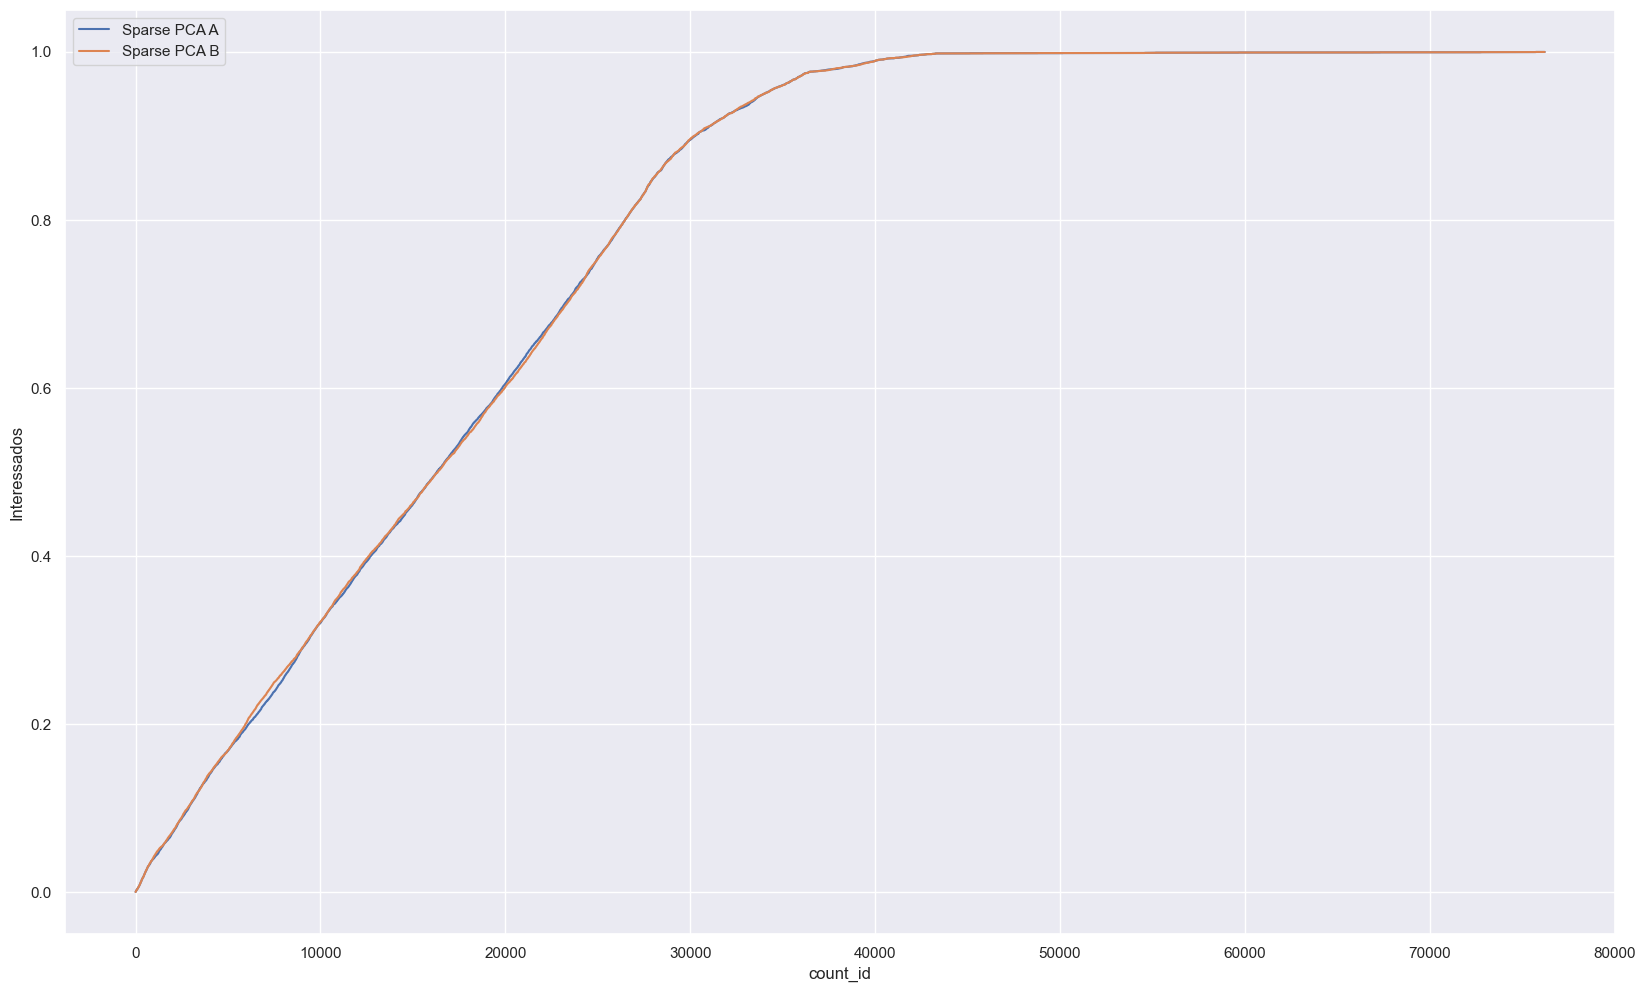

In [330]:
metrics_pcaA = perncentage_target( y_val=y_val, yhat=yhat_lr_pca4 )
metrics_pcaB = perncentage_target( y_val=y_val, yhat=yhat_lr_pcaB )

figure(figsize=(20,12))
sns.lineplot(x='count_id', y='Interessados', data=metrics_pcaA , label='Sparse PCA A')
sns.lineplot(x='count_id', y='Interessados', data=metrics_pcaB , label='Sparse PCA B')

#### Truncated SVD (Singular Value Decomposition)

In [340]:
# TruncatedSVD A
tsvdA = TruncatedSVD( n_components= 4, random_state= 123 )
x_train_tsvdA = tsvdA.fit_transform( df5.drop( ['id','response'], axis=1 ) )
x_val_tsvdA   = tsvdA.fit_transform( x_val_raw.drop( ['id'], axis=1 ) )

# model
lr_model_tsvdA = LogisticRegression()

# training
lr_model_tsvdA.fit( x_train_tsvdA, y_train )

# model prediction - poder de GENERALIZAÇÃO
yhat_lr_tsvdA = lr_model_tsvdA.predict_proba( x_val_tsvdA )



In [341]:
# TruncatedSVD B
tsvdB = TruncatedSVD( n_components= 3, random_state= 123 )
x_train_tsvdB = tsvdB.fit_transform( df5.drop( ['id','response'], axis=1 ) )
x_val_tsvdB   = tsvdB.fit_transform( x_val_raw.drop( ['id'], axis=1 ) )

# model
lr_model_tsvdB = LogisticRegression()

# training
lr_model_tsvdB.fit( x_train_tsvdB, y_train )

# model prediction - poder de GENERALIZAÇÃO
yhat_lr_tsvdB = lr_model_tsvdB.predict_proba( x_val_tsvdB )

<AxesSubplot: xlabel='count_id', ylabel='Interessados'>

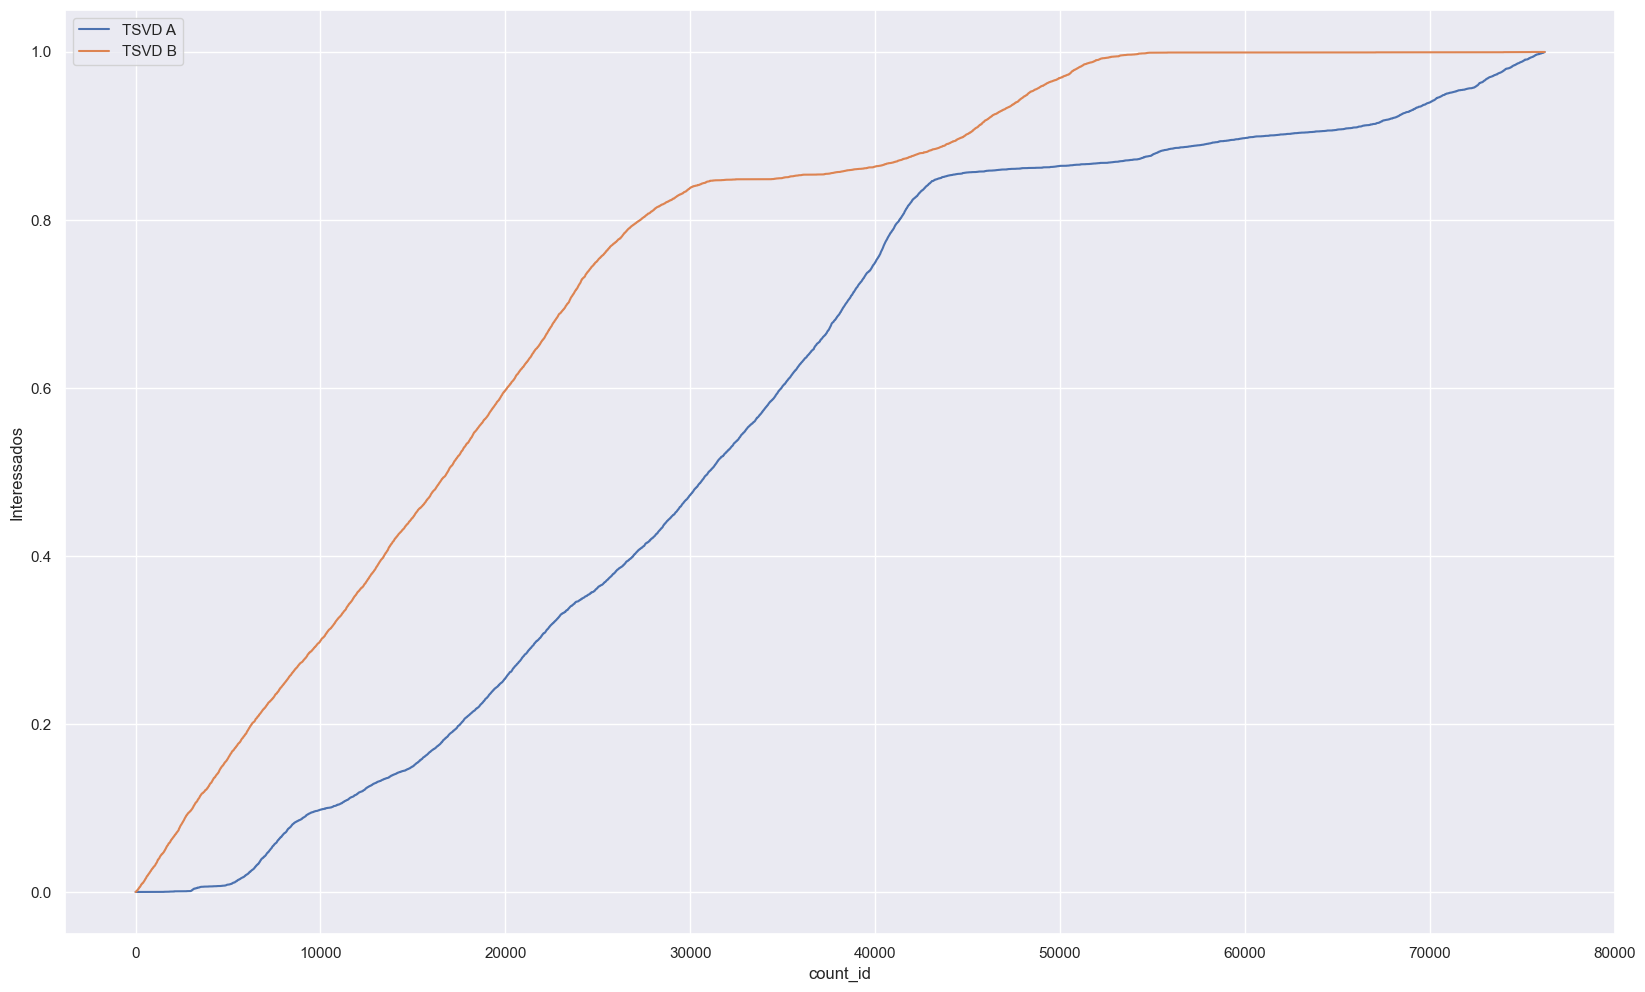

In [342]:
metrics_tsvdA = perncentage_target( y_val=y_val, yhat=yhat_lr_tsvdA )
metrics_tsvdB = perncentage_target( y_val=y_val, yhat=yhat_lr_tsvdB )

figure(figsize=(20,12))
sns.lineplot(x='count_id', y='Interessados', data=metrics_tsvdA , label='TSVD A')
sns.lineplot(x='count_id', y='Interessados', data=metrics_tsvdB , label='TSVD B')

### 3.2.4. RandomForestClassifier

In [334]:
# model
rfc_model = RandomForestClassifier( n_estimators = 100, n_jobs = -1 )

# training
rfc_model.fit( x_train, y_train )

# model prediction - poder de GENERALIZAÇÃO
yhat_rfc =rfc_model.predict_proba( x_val )


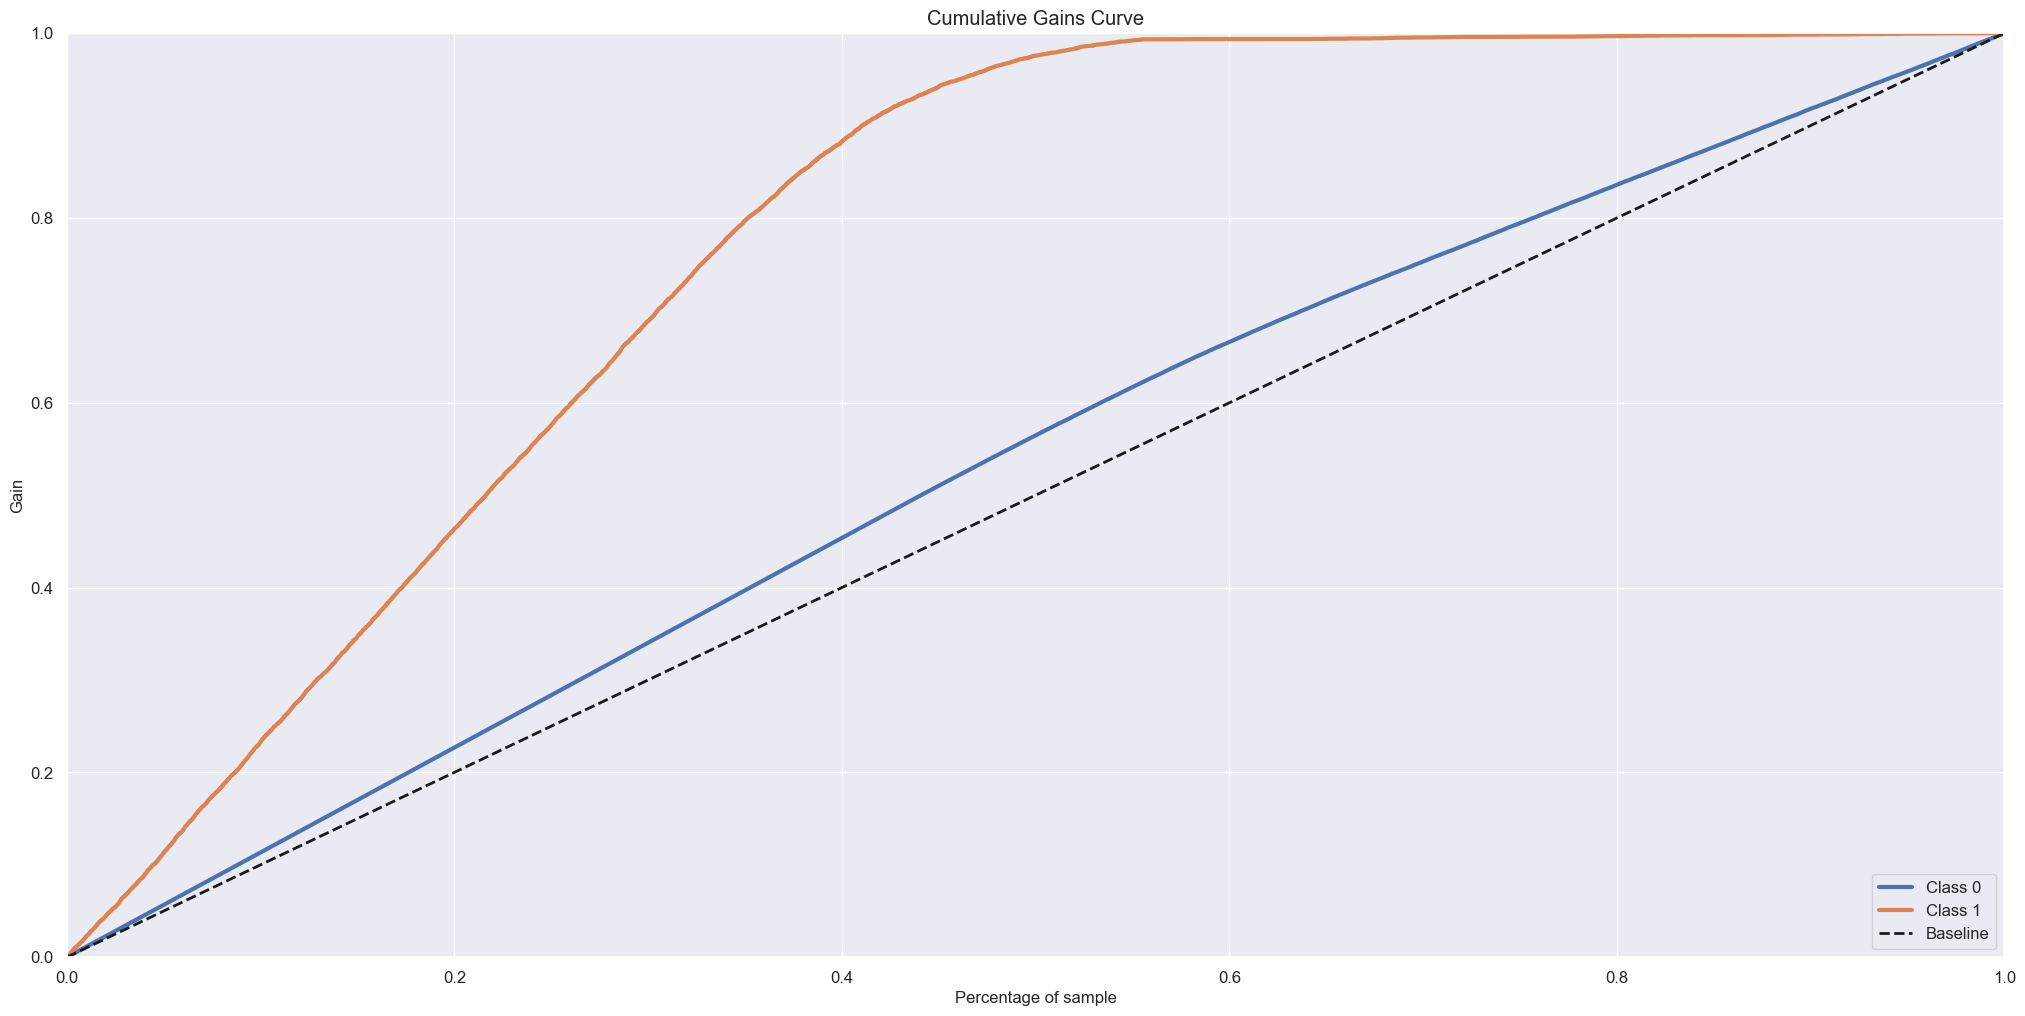

In [335]:
# Accumulative Gain lr
skplot.metrics.plot_cumulative_gain( y_val, yhat_rfc );

### 3.2.3. Metricas

In [ ]:
def perncentage_target ( y_val=y_val, yhat=yhat_lr_tsvd ):
    df_metric = pd.DataFrame( y_val )
    df_metric['predict'] = yhat[:,1]
    df_metric = df_metric.sort_values( by='predict', ascending=False )
    df_metric['cumsum'] = df_metric['response'].cumsum()
    df_metric = df_metric.assign( Interessados = lambda x: (x['cumsum']/df_metric['response'].sum() ) )
    df_metric['count_id'] = np.linspace( 1, df_metric.shape[0], df_metric.shape[0])#/df_metric.shape[0]

    return df_metric

<AxesSubplot: xlabel='count_id', ylabel='Interessados'>

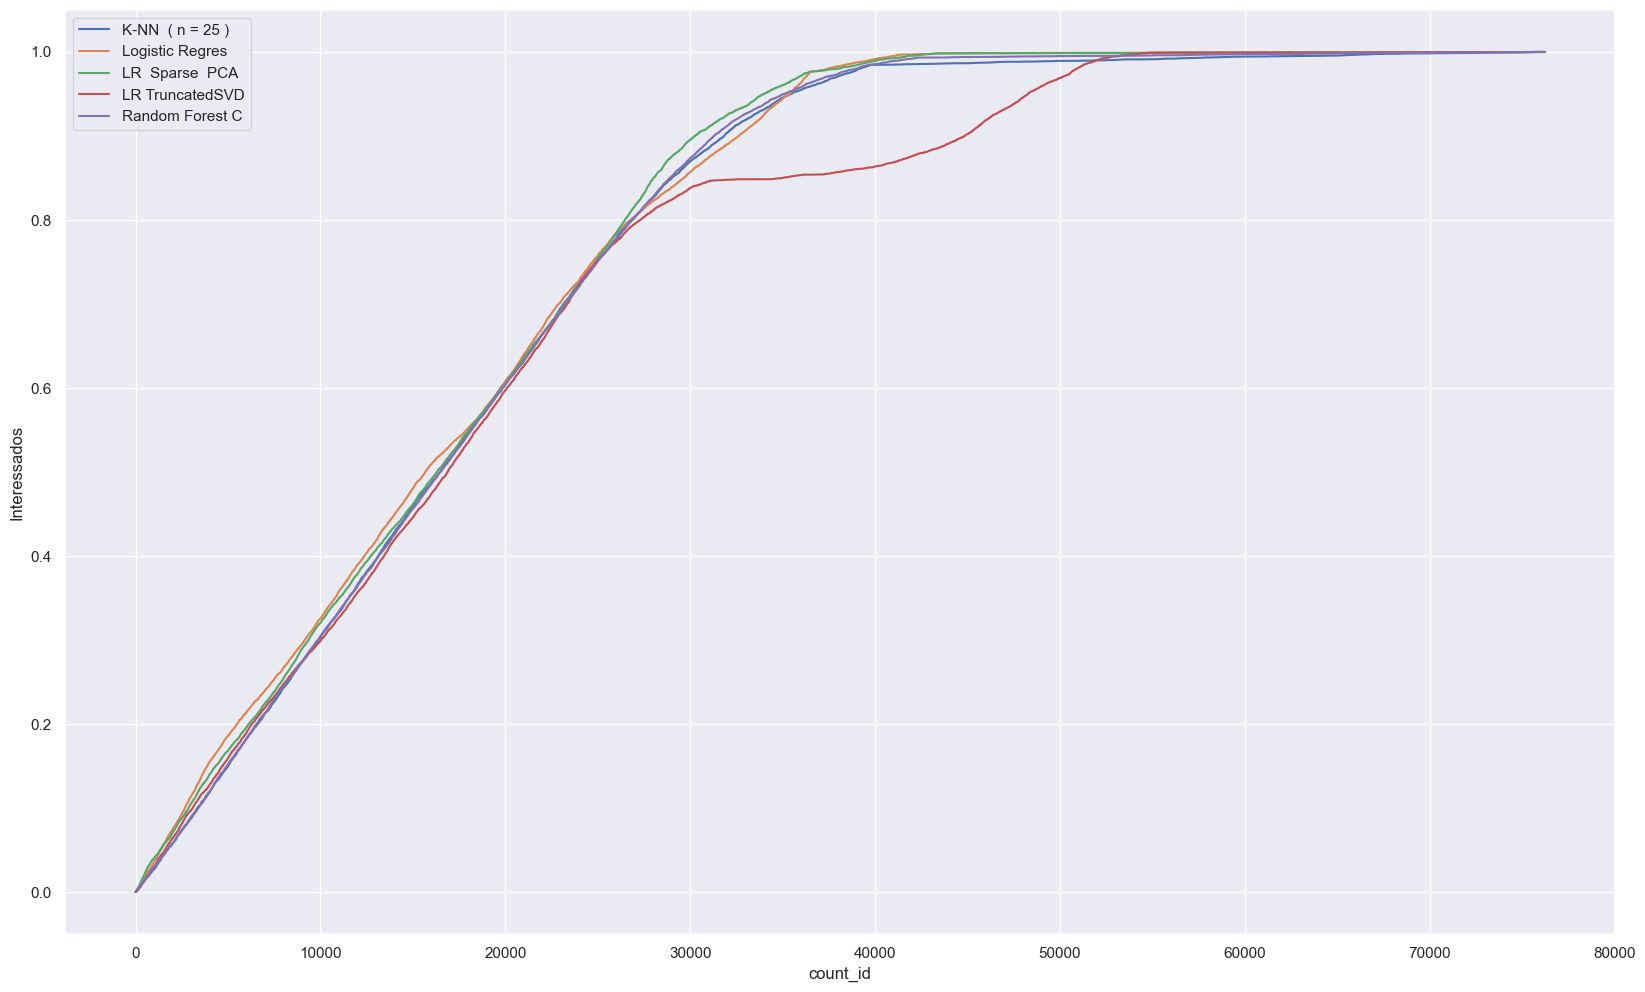

In [343]:
metrics_knn  = perncentage_target( y_val=y_val, yhat=yhat_knn25 )
metrics_lr   = perncentage_target( y_val=y_val, yhat=yhat_lr )
metrics_tsvd = perncentage_target( y_val=y_val, yhat=yhat_lr_tsvdB )
metrics_pca  = perncentage_target( y_val=y_val, yhat=yhat_lr_pca4 )
metrics_rfc  = perncentage_target( y_val=y_val, yhat=yhat_rfc )

figure(figsize=(20,12))
sns.lineplot(x='count_id', y='Interessados', data=metrics_knn25 , label='K-NN  ( n = 25 )')
sns.lineplot(x='count_id', y='Interessados', data=metrics_lr    , label='Logistic Regres ')
sns.lineplot(x='count_id', y='Interessados', data=metrics_pca   , label='LR  Sparse  PCA')
sns.lineplot(x='count_id', y='Interessados', data=metrics_tsvd  , label='LR TruncatedSVD')
sns.lineplot(x='count_id', y='Interessados', data=metrics_rfc   , label='Random Forest C')